In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import sklearn.preprocessing
from torchmetrics.regression import MeanAbsolutePercentageError

C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
#prepare data
df = pd.read_csv("cgm_data.csv")#shuffle data rows (patients)
for column in df.columns:
    df[column] = df[column].astype(float) #convert columns into floats
ptids = df["ptid"]
df = df.drop("ptid",axis=1)
df = df.iloc[:96,:] # keep only 96 patients

In [3]:
#create model
class SimpleLinear(torch.nn.Module):
    def __init__(self,input_size, device='cpu'):
        super(SimpleLinear, self).__init__()
        self.input_size = input_size
        self.device = device
        self.linear1 = torch.nn.Linear(self.input_size, 1, device=self.device).double()

    def forward(self,x):
        x = self.linear1(x)
        return x

In [46]:
def train_test_split(df, train_size, lookback_size, prediction_horizon):
    train_df = df.iloc[:train_size,:]
    test_df =  df.iloc[90:,:]

    train_ptids = np.array(range(0,train_size))
    train_ptids = np.expand_dims(train_ptids,1)
    test_ptids = np.array(range(90,len(df)))
    test_ptids = np.expand_dims(test_ptids,1)

    train_x = []
    train_y = []
    test_x = []
    test_y = []
    for i in range(len(df.columns)-lookback_size - prediction_horizon + 1):
        train_row = train_df.iloc[:,i:i+lookback_size].values
        train_row = np.append(train_ptids,train_row,axis=1)
        train_x.append(train_row)
        train_y.append(train_df.iloc[:,i+lookback_size+prediction_horizon-1].values)

        test_row = test_df.iloc[:,i:i+lookback_size].values
        test_row = np.append(test_ptids,test_row,axis=1)
        test_x.append(test_row)
        test_y.append(test_df.iloc[:,i+lookback_size+prediction_horizon-1].values)

    train_x = torch.from_numpy(np.array(train_x)).to(device) # [batch,patient id,sequence]
    train_y = torch.from_numpy(np.array(train_y)).to(device) # [batch,patient id]
    test_x = torch.from_numpy(np.array(test_x)).to(device)
    test_y = torch.from_numpy(np.array(test_y)).to(device)
    return train_x, train_y, test_x, test_y

# Inital loss curve

In [9]:
device = 'cuda'
train_size = 90 
lookback_size = 20
epochs = 100
learning_rate = 0.0001
prediction_horizon = 1

In [10]:
#instantiate model
model = SimpleLinear(input_size=lookback_size+1,device=device)
criterion = MeanAbsolutePercentageError().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
train_x, train_y, test_x, test_y = train_test_split(df, train_size, lookback_size, prediction_horizon)
#train and test model
losses = []
test_losses = []
for i in tqdm(range(epochs)):
    for j in range(0,train_x.shape[0]):
        batch_x = train_x[j,:,:]
        batch_y = train_y[j,:]
        
        model.zero_grad()
        out = model(batch_x)
        loss = criterion(out,batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    
    with torch.no_grad():
        pred = model(torch.reshape(test_x, [-1,lookback_size+1]))
        loss = criterion(pred.squeeze(1), torch.reshape(test_y,[-1]))
        test_losses.append(loss.item())
        

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


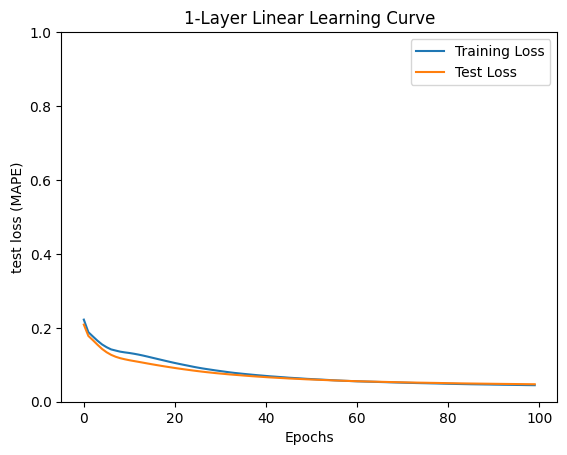

0.04727424308657646

In [12]:
#Training Curve
plt.figure()
plt.plot(range(len(losses)), losses, label = "Training Loss")
plt.plot(range(len(test_losses)), test_losses, label = "Test Loss")
plt.ylabel("test loss (MAPE)")
plt.xlabel("Epochs")
plt.ylim(0,1)
plt.title("1-Layer Linear Learning Curve")
plt.legend()
plt.show()
test_losses[-1]

In [13]:
predicted = np.reshape(pred.to("cpu"),[-1,len(df)-train_size])

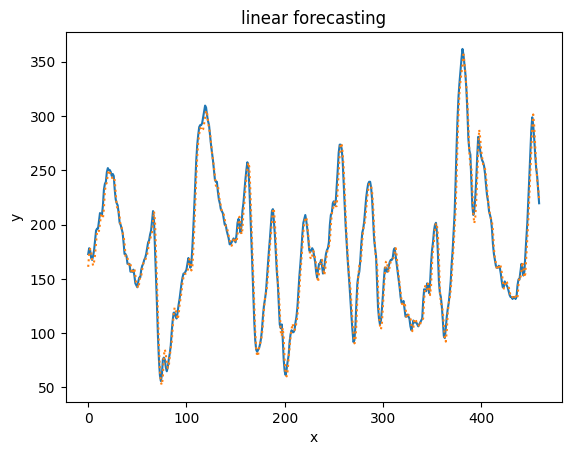

In [14]:
plt.figure()
plt.title("linear forecasting")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks()
plt.yticks()
plt.plot(np.arange(test_y.shape[0]), test_y.to("cpu")[:,2])
plt.plot(np.arange(test_y.shape[0]), predicted[:,2], ":")
plt.show()

# Graph 2 Variable Time Horizon

In [31]:
device = 'cuda'
train_size = 90 
lookback_size = 20
epochs = 100
learning_rate = 0.0001
prediction_horizons = [1,2,3,4,5,6,7,8]

In [32]:
final_test_loss = []
for prediction_horizon in prediction_horizons:
    train_x, train_y, test_x, test_y = train_test_split(df, train_size, lookback_size, prediction_horizon)
    model = SimpleLinear(input_size=lookback_size+1,device=device)
    criterion = MeanAbsolutePercentageError().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #train and test model
    losses = []
    test_losses = []
    for i in tqdm(range(epochs)):
        for j in range(0,train_x.shape[0]):
            batch_x = train_x[j,:,:]
            batch_y = train_y[j,:]

            model.zero_grad()
            out = model(batch_x)
            loss = criterion(out,batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()
        losses.append(loss.item())

        with torch.no_grad():
            pred = model(torch.reshape(test_x, [-1,lookback_size+1]))
            loss = criterion(pred.squeeze(1), torch.reshape(test_y,[-1]))
            test_losses.append(loss.item())
    final_test_loss.append(test_losses[-1])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


In [33]:
[15*x for x in prediction_horizons]

[15, 30, 45, 60, 75, 90, 105, 120]

In [34]:
final_test_loss

[0.0474713072180748,
 0.08954135328531265,
 0.11740496754646301,
 0.14323735237121582,
 0.16422633826732635,
 0.18126924335956573,
 0.19718515872955322,
 0.2072678655385971]

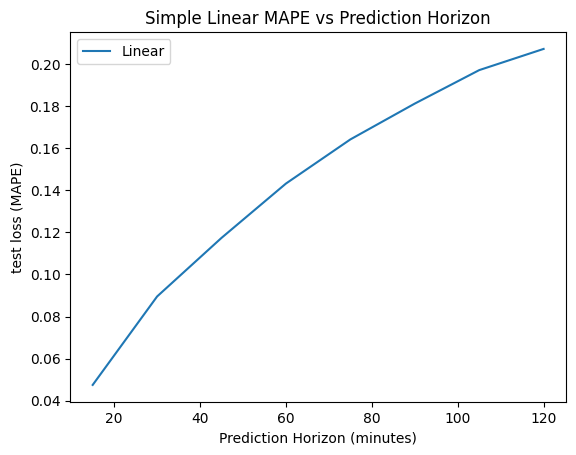

In [35]:
#Training Curve
plt.figure()
plt.plot([15*x for x in prediction_horizons],final_test_loss, label = "Linear")
plt.legend()
plt.ylabel("test loss (MAPE)")
plt.xlabel("Prediction Horizon (minutes)")
plt.title("Simple Linear MAPE vs Prediction Horizon")
plt.legend()
plt.show()

## Graph 3 Variable Training Patients 


In [54]:
device = 'cuda'
train_sizes = [1,10,20,30,40,50,60,70,80,90] 
lookback_size = 20
epochs = 100
learning_rate = 0.0001
prediction_horizon = 3

In [55]:
final_test_loss = []
for train_size in train_sizes:
    train_x, train_y, test_x, test_y = train_test_split(df, train_size, lookback_size, prediction_horizon)
    #instantiate model
    model = SimpleLinear(input_size=lookback_size+1,device=device)
    criterion = MeanAbsolutePercentageError().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #train and test model
    losses = []
    test_losses = []
    for i in tqdm(range(epochs)):
        for j in range(0,train_x.shape[0]):
            batch_x = train_x[j,:,:]
            batch_y = train_y[j,:]

            model.zero_grad()
            out = model(batch_x)
            loss = criterion(out,batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()
        losses.append(loss.item())

        with torch.no_grad():
            pred = model(torch.reshape(test_x, [-1,lookback_size+1]))
            loss = criterion(pred.squeeze(1), torch.reshape(test_y,[-1]))
            test_losses.append(loss.item())
    final_test_loss.append(test_losses[-1])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


In [56]:
train_sizes = [1,10,20,30,40,50,60,70,80,90] 

In [57]:
final_test_loss

[0.18195824325084686,
 0.31417301297187805,
 0.2058764398097992,
 0.14402209222316742,
 0.12802131474018097,
 0.12182428687810898,
 0.11928587406873703,
 0.11962181329727173,
 0.11945906281471252,
 0.11737339198589325]

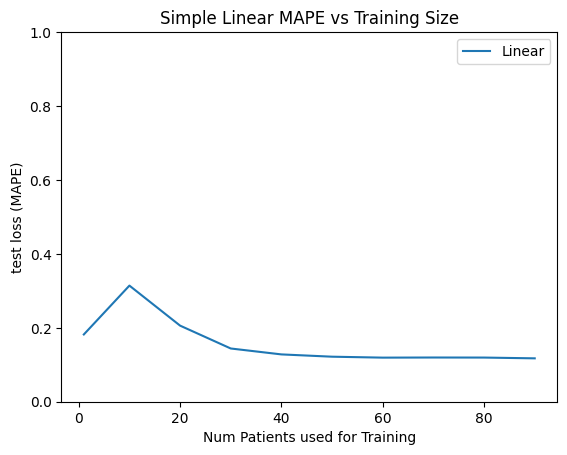

In [58]:
#Training Curve
plt.figure()
plt.ylim(0,1)
plt.plot(train_sizes,final_test_loss, label = "Linear")
plt.ylabel("test loss (MAPE)")
plt.xlabel("Num Patients used for Training")
plt.title("Simple Linear MAPE vs Training Size")
plt.legend()
plt.show()